7000 3000
torch.Size([3, 128, 128]) 1
train/fake/UZXNZKPGE7.jpg 0
0
Valid samples: 3000
Using device: cuda
[Valid] loss=0.7031, acc=0.8193
可视化样例已保存到: pred_examples.png


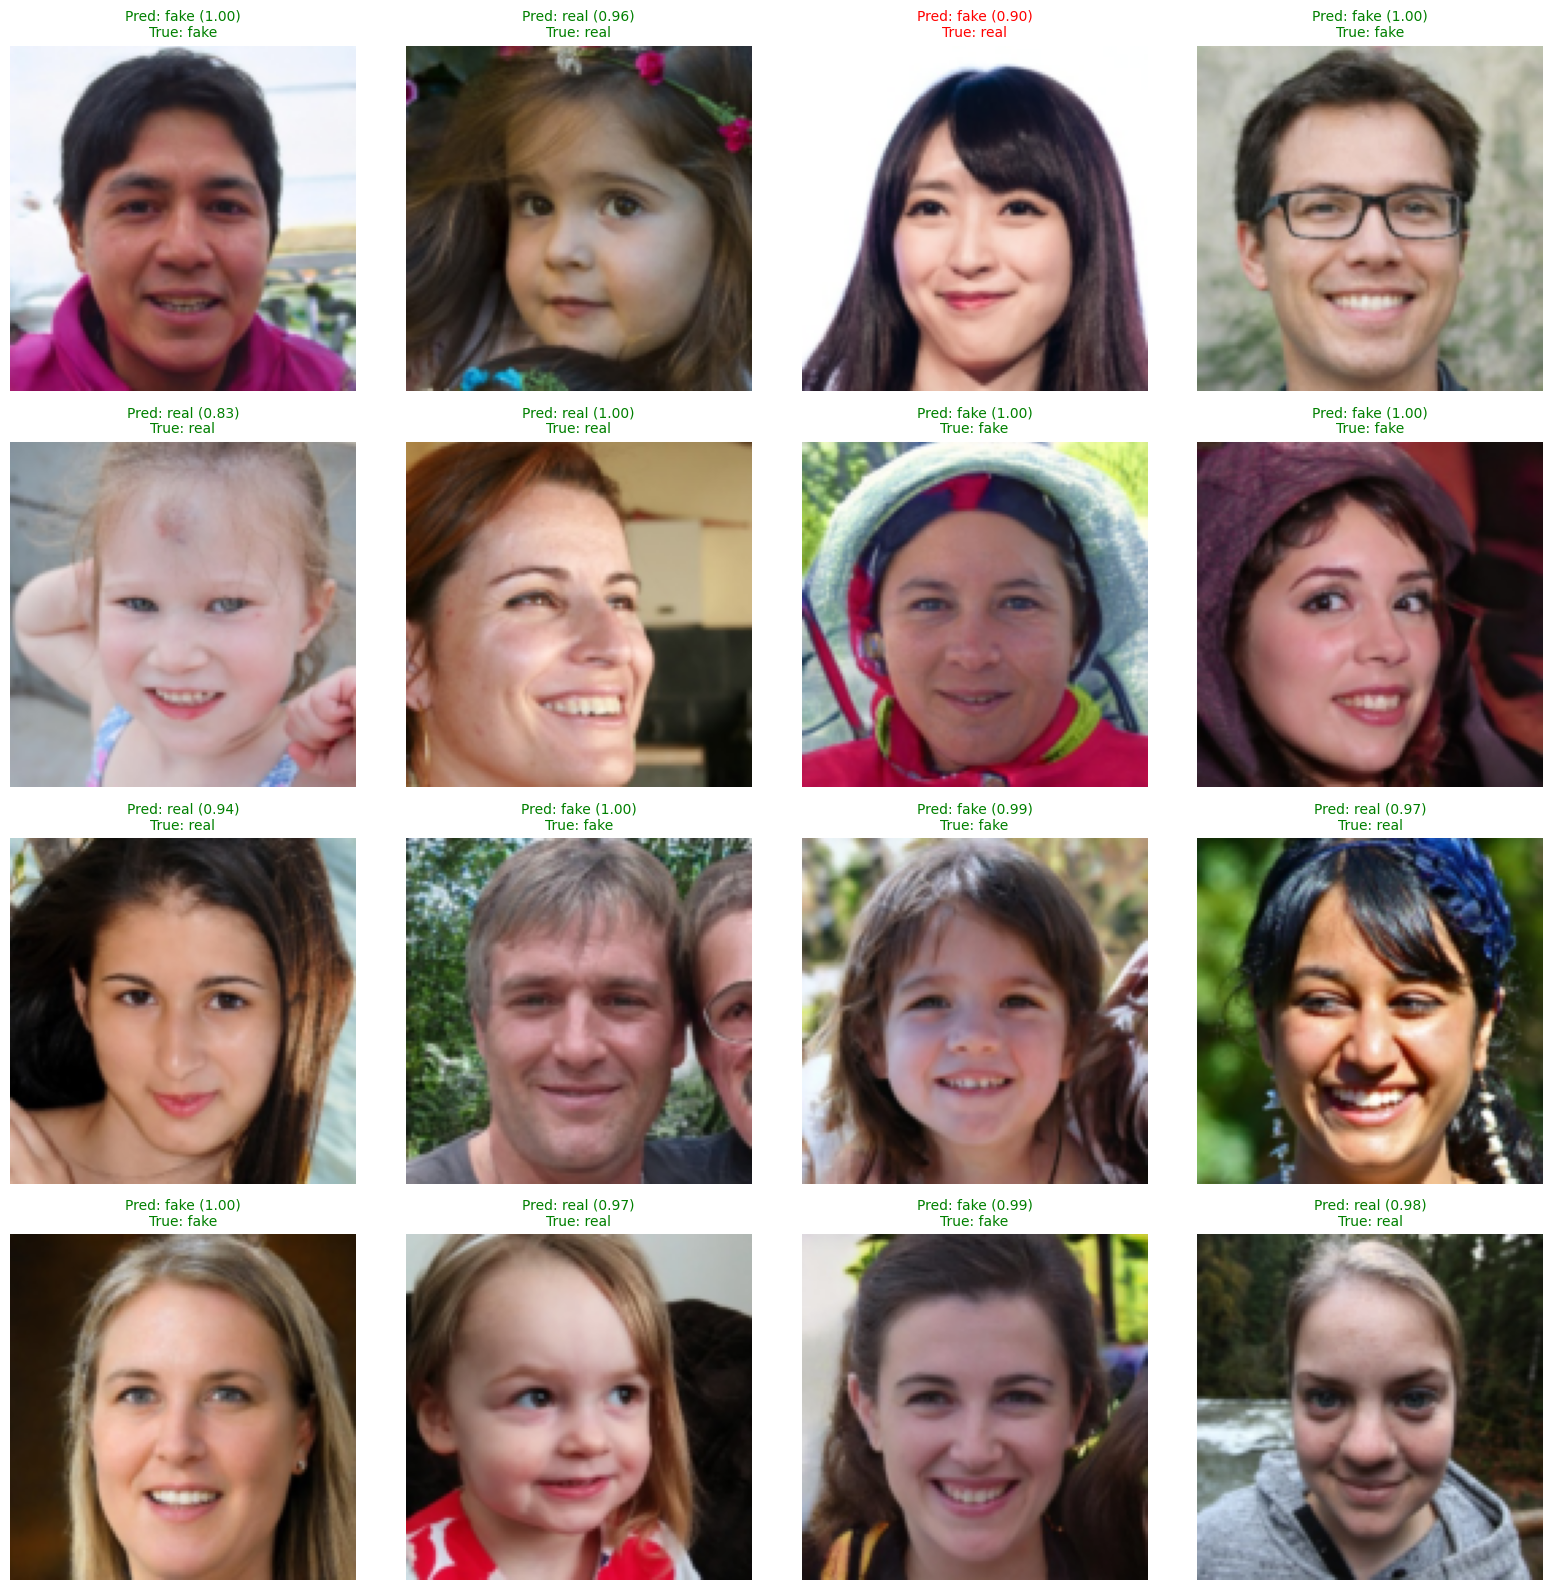

In [1]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

from dataloader import *
from utils import get_dataset_paths


# ------------------------
# 加载模型
# ------------------------
def load_model(weight_path, num_classes=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 结构要和训练时一致
    model = models.resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    state_dict = torch.load(weight_path, map_location=device)
    model.load_state_dict(state_dict)

    model = model.to(device)
    model.eval()
    return model, device


# ------------------------
# 评估 valid 集 accuracy
# ------------------------
@torch.no_grad()
def evaluate(model, loader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device).long()

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


# ------------------------
# 可视化若干预测结果
# ------------------------
@torch.no_grad()
def visualize_predictions(
    model, dataset, device, num_images=16, save_path="pred_examples.png"
):
    """
    从 dataset 中随机选 num_images 张图片，画成网格：
    标题显示：Pred/True/Prob，预测正确为绿色，错误为红色
    """
    model.eval()
    class_names = {0: "fake", 1: "real"}

    # 随机挑选若干 index
    num_images = min(num_images, len(dataset))
    indices = random.sample(range(len(dataset)), num_images)

    # 画网格
    n_cols = 4
    n_rows = int(np.ceil(num_images / n_cols))

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))

    for i, idx in enumerate(indices):
        img_tensor, label = dataset[idx]  # 已经是 [C,H,W] 且归一化后的张量

        # 模型输入
        input_tensor = img_tensor.unsqueeze(0).to(device)  # [1,C,H,W]
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        pred = torch.argmax(probs).item()
        prob = probs[pred].item()

        # 反归一化到 [0,1] 方便展示
        # 训练时是 (x - 0.5) / 0.5 -> 反过来 x = x * 0.5 + 0.5
        img_np = img_tensor.numpy().transpose(1, 2, 0)
        img_np = img_np * 0.5 + 0.5
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img_np)
        plt.axis("off")

        title_color = "green" if pred == label else "red"
        title = f"Pred: {class_names[pred]} ({prob:.2f})\nTrue: {class_names[label]}"
        plt.title(title, color=title_color, fontsize=10)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    print(f"可视化样例已保存到: {save_path}")
    # 如果你在本地运行，也可以 plt.show()
    # plt.show()


# ------------------------
# 5. 主函数：加载 valid 集 → 评估 → 可视化
# ------------------------
def main():
    # 和训练时保持一致的 img_size 和 Normalize
    img_size = 128

    valid_tf = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    _, root_dir, _, valid_csv_path = get_dataset_paths()

    valid_dataset = FaceRealFakeDataset(valid_csv_path, root_dir, transform=valid_tf)
    valid_loader = DataLoader(
        valid_dataset, batch_size=64, shuffle=False, num_workers=4
    )

    print("Valid samples:", len(valid_dataset))

    # 1) 加载训练好的模型
    weight_path = "best_resnet18_rvf10k.pth"  # 按你保存的文件名改
    model, device = load_model(weight_path, num_classes=2)

    # 2) 先整体算一下 valid 的 loss / acc
    val_loss, val_acc = evaluate(model, valid_loader, device)
    print(f"[Valid] loss={val_loss:.4f}, acc={val_acc:.4f}")

    # 3) 再随机抽几张图做可视化网格
    visualize_predictions(
        model, valid_dataset, device, num_images=16, save_path="pred_examples.png"
    )


if __name__ == "__main__":
    main()
